# Classify using latent features

In [0]:
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
os.chdir('/content/tybalt')
!pwd


/content/tybalt


In [3]:
!ls

adage_training.ipynb	       param_sweep
config			       param_sweep_adage
data			       param_sweep.sh
disease_names.csv	       param_sweep_twohidden
download_data.sh	       param_sweep_twohidden300
environment.yml		       process_data.ipynb
extract_tybalt_weights.ipynb   README.md
figures			       results
gpu-environment.yml	       scripts
hgsc_subtypes_tybalt.ipynb     setup.py
high_weight_genes.ipynb        tsne_tybalt_features.ipynb
latent_space_comparison.ipynb  tybalt
LICENSE.md		       tybalt_twohidden.ipynb
models			       tybalt_vae.ipynb
parameter_sweep.md


In [4]:
!ls data

background_genes.txt
clinical_data.tsv
encoded_adage_features.tsv
encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv
encoded_rnaseq_onehidden_warmup_batchnorm.tsv
encoded_rnaseq_twohidden_100model.tsv.gz
encoded_rnaseq_twohidden_300model.tsv.gz
gene_reconstruction_fidelity-25dim.tsv
gene_reconstruction_fidelity_36dim.tsv
oncokb_genetypes.tsv
onehidden_warmup_batchnorm_tsne_out.tsv
ov_subtype_info.tsv
pancan_mutation_burden.tsv
pancan_mutation.tsv.gz
pancan_scaled_rnaseq.tsv.gz
pancan_scaled_zeroone_rnaseq.tsv.gz
patient_reconstruction_fidelity-25dim.tsv
patient_reconstruction_fidelity_36dim.tsv
raw
status_matrix.tsv.gz
tcga_colors.tsv
tybalt_features_with_clinical.tsv
tybalt_gene_weights_twohidden100.tsv
tybalt_gene_weights_twohidden300.tsv


In [5]:
activation_file = os.path.join('data', 'encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv')
activations = pd.read_table(activation_file)
activations['sample_id']=activations.tcga_id.apply(lambda x:x[:12])
print(activations.shape)
activations.head(3)

(10459, 38)


,tcga_id,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,sample_id
0,TCGA-02-0047-01,0.0,0.000000,0.0,9.652770,0.0,4.159220,1.032724,1.333893,0.000000,...,4.095537,0.000000,0.0,0.248807,0.272327,3.184963,0.0,2.675518,0.000000,TCGA-02-0047
1,TCGA-02-0055-01,0.0,1.512052,0.0,4.649414,0.0,3.986379,1.551740,6.000260,0.000000,...,3.933533,0.000000,0.0,0.000000,0.299276,0.604121,0.0,0.000000,0.000000,TCGA-02-0055
2,TCGA-02-2483-01,0.0,3.843754,0.0,7.305416,0.0,6.712879,0.000000,3.738884,0.382847,...,6.744939,0.401072,0.0,1.256845,0.000000,3.929856,0.0,6.264098,0.502557,TCGA-02-2483


In [6]:
clinical_file = os.path.join('data', 'clinical_data.tsv')
cases = pd.read_table(clinical_file)
diagnosis = cases[['sample_id', 'acronym', 'gender']]
diagnosis.head()

,sample_id,acronym,gender
0,TCGA-CD-8534,STAD,male
1,TCGA-ER-A19A,SKCM,male
2,TCGA-C5-A1M8,CESC,female
3,TCGA-D1-A0ZN,UCEC,female
4,TCGA-EM-A4FF,THCA,female


In [7]:
activations = pd.merge(activations, diagnosis, how='left')
activations.shape

(12175, 40)

In [8]:
X = activations[[str(i) for i in range(1,37)]]
X.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,0.0,0.000000,0.000000,9.652770,0.0,4.159220,1.032724,1.333893,0.000000,0.000000,...,0.205776,4.095537,0.000000,0.000000,0.248807,0.272327,3.184963,0.000000,2.675518,0.000000
1,0.0,1.512052,0.000000,4.649414,0.0,3.986379,1.551740,6.000260,0.000000,0.535351,...,0.000000,3.933533,0.000000,0.000000,0.000000,0.299276,0.604121,0.000000,0.000000,0.000000
2,0.0,3.843754,0.000000,7.305416,0.0,6.712879,0.000000,3.738884,0.382847,0.000000,...,0.220688,6.744939,0.401072,0.000000,1.256845,0.000000,3.929856,0.000000,6.264098,0.502557
3,0.0,1.455699,0.000000,10.665386,0.0,5.645957,0.928695,1.088772,0.793327,0.000000,...,0.633842,8.387358,1.342886,0.000000,0.329535,0.000000,0.042516,0.241667,0.288800,1.574040
4,0.0,3.477089,0.759481,9.945347,0.0,7.444561,4.212522,0.000000,2.190329,0.000000,...,1.397643,2.803812,0.000000,0.695088,0.000000,2.402303,0.000000,0.114442,0.000000,0.513113


In [0]:
y1 = activations['acronym']

In [10]:
y1.value_counts()

BRCA    1498
KIRC     762
LUAD     732
THCA     706
PRAD     668
LUSC     657
HNSC     638
LGG      564
LIHC     529
STAD     516
SKCM     481
BLCA     472
COAD     443
KIRP     389
OV       318
CESC     317
SARC     277
UCEC     225
ESCA     222
PCPG     205
PAAD     193
GBM      187
TGCT     168
KICH     141
THYM     126
READ     122
LAML     121
MESO      87
UVM       80
ACC       79
CHOL      63
UCS       57
DLBC      48
Name: acronym, dtype: int64

In [0]:
y2=activations['gender']

In [13]:
y2.value_counts()

male      6050
female    6001
Name: gender, dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2)

In [32]:
y_train.value_counts()

BRCA    1211
KIRC     600
LUAD     592
THCA     564
PRAD     547
LUSC     524
HNSC     512
LGG      462
LIHC     420
STAD     405
SKCM     395
BLCA     391
COAD     354
KIRP     300
CESC     260
OV       252
SARC     213
ESCA     184
UCEC     183
PCPG     161
PAAD     146
GBM      140
TGCT     132
KICH     117
READ      98
LAML      95
THYM      94
ACC       67
UVM       63
MESO      62
CHOL      51
UCS       43
DLBC      38
Name: acronym, dtype: int64

In [33]:
y_test.value_counts()

BRCA    287
KIRC    162
THCA    142
LUAD    140
LUSC    133
HNSC    126
PRAD    121
STAD    111
LIHC    109
LGG     102
COAD     89
KIRP     89
SKCM     86
BLCA     81
OV       66
SARC     64
CESC     57
GBM      47
PAAD     47
PCPG     44
UCEC     42
ESCA     38
TGCT     36
THYM     32
LAML     26
MESO     25
KICH     24
READ     24
UVM      17
UCS      14
ACC      12
CHOL     12
DLBC     10
Name: acronym, dtype: int64

In [61]:
rf = RandomForestClassifier(n_estimators=1000, verbose=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
rf.score(X_train, y_train)

0.993429158110883

In [63]:
rf.score(X_test, y_test)

0.9359342915811089

In [41]:
sorted(list(zip(X.columns,list(rf.feature_importances_))), key=lambda k:k[1], reverse=True)

[('3', 0.06012481687103193),
 ('19', 0.056814501161891136),
 ('25', 0.048834096603399046),
 ('10', 0.044119555807158525),
 ('36', 0.04314329555362997),
 ('4', 0.04296321081192021),
 ('1', 0.04020532354060233),
 ('31', 0.03701556372288047),
 ('17', 0.03693939671180708),
 ('7', 0.03595179949546667),
 ('5', 0.03557366933461094),
 ('34', 0.03430685884685295),
 ('11', 0.032766235490718956),
 ('14', 0.03234958151457595),
 ('15', 0.03216852843865078),
 ('30', 0.030138078062936773),
 ('20', 0.02924429680962084),
 ('32', 0.02729397426442813),
 ('33', 0.024510418353753345),
 ('26', 0.02416163674811784),
 ('18', 0.024057265841408926),
 ('16', 0.020314845618213076),
 ('21', 0.020107747672709113),
 ('12', 0.019759979266421448),
 ('27', 0.01961031633352047),
 ('29', 0.01822648965313485),
 ('22', 0.017447256289642457),
 ('8', 0.016336919386230477),
 ('23', 0.01576441888739718),
 ('35', 0.015437295118916863),
 ('28', 0.015296172128470013),
 ('6', 0.014601621918605841),
 ('13', 0.009681266756160321),
 

In [0]:
y_pred = rf.predict(X_test)

In [0]:
confusion = pd.crosstab(y_pred, y_test)

In [47]:
confusion

acronym,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
row_0,,,,,,,,,,,,,,,,,,,,,
ACC,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BLCA,0,75,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
BRCA,0,0,286,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CESC,0,0,0,54,0,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,0
CHOL,0,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COAD,0,0,0,0,0,88,0,0,0,0,...,18,0,0,3,0,0,0,0,0,0
DLBC,0,0,0,0,0,0,9,0,0,0,...,0,0,0,1,0,0,0,0,0,0
ESCA,0,1,0,0,0,0,0,20,0,1,...,0,0,0,2,0,0,0,0,0,0
GBM,0,0,0,0,0,0,0,0,36,0,...,0,0,0,0,0,0,0,0,0,0


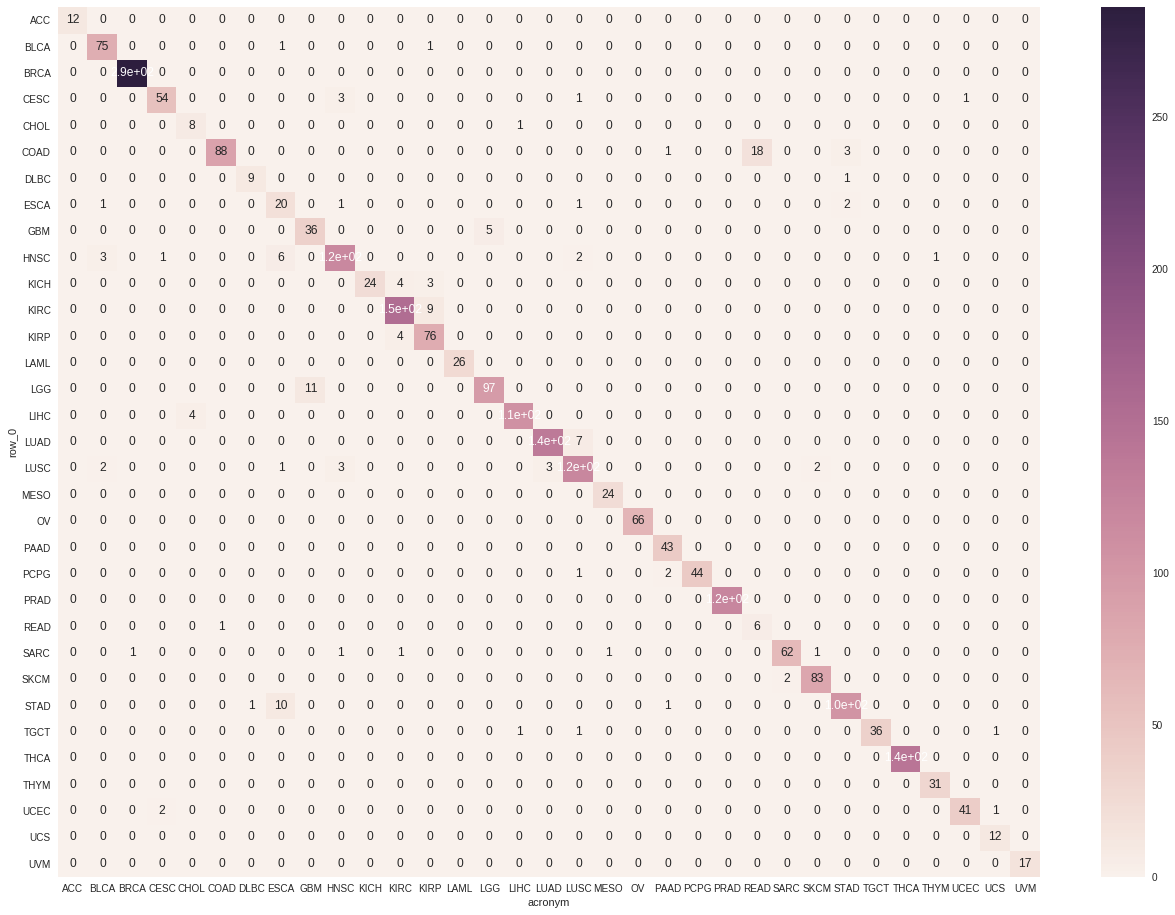

In [60]:
import seaborn as sns

sns.set(rc={'figure.figsize':(22,16)})
ax = sns.heatmap(confusion, annot=True)

In [0]:
X_train.shape

(9740, 36)

In [0]:
from collections import Counter

confusions=Counter()
for i in range(X_test.shape[0]):
  pred=rf.predict([X_test.values[i]])[0]
  actual=y_test.values[i]
  if pred!=actual:
    print(i,pred,actual,pred==actual)
    confusions[pred,actual]+=1

(4, 'STAD', 'ESCA', False)
(35, 'COAD', 'PAAD', False)
(37, 'UCEC', 'LUAD', False)
(91, 'LIHC', 'CHOL', False)
(104, 'COAD', 'READ', False)
(109, 'HNSC', nan, False)
(117, 'GBM', 'LGG', False)
(124, 'LUAD', 'LUSC', False)
(125, 'HNSC', 'LUSC', False)
(147, 'HNSC', 'LUSC', False)
(154, 'HNSC', 'ESCA', False)
(168, 'SARC', 'MESO', False)
(227, 'HNSC', 'LUSC', False)
(252, 'PAAD', 'STAD', False)
(254, 'COAD', 'READ', False)
(262, 'STAD', 'ESCA', False)
(273, 'COAD', 'READ', False)
(291, 'STAD', 'CHOL', False)
(294, 'LUSC', 'ESCA', False)
(300, 'KIRC', 'KIRP', False)
(306, 'LIHC', 'CHOL', False)
(320, 'COAD', 'READ', False)
(329, 'LGG', 'GBM', False)
(357, 'STAD', 'OV', False)
(368, 'KIRC', 'KIRP', False)
(381, 'GBM', 'LGG', False)
(389, 'LUSC', 'LUAD', False)
(404, 'COAD', 'READ', False)
(412, 'LUSC', 'LUAD', False)
(424, 'LUAD', 'LUSC', False)
(429, 'UCEC', 'OV', False)
(438, 'STAD', 'ESCA', False)
(469, 'LIHC', 'CHOL', False)
(527, 'HNSC', 'ESCA', False)
(531, 'SARC', 'ACC', False)
(542

In [0]:
for d,c in confusions.most_common():
  print(d,c)

(('COAD', 'READ'), 17)
(('STAD', 'ESCA'), 14)
(('LUAD', 'LUSC'), 9)
(('LGG', 'GBM'), 8)
(('LAML', nan), 7)
(('LUSC', 'LUAD'), 6)
(('KIRC', 'KIRP'), 5)
(('HNSC', 'ESCA'), 5)
(('HNSC', 'LUSC'), 5)
(('LIHC', 'CHOL'), 4)
(('GBM', 'LGG'), 4)
(('LUSC', 'HNSC'), 3)
(('HNSC', nan), 3)
(('KIRP', 'KIRC'), 3)
(('BRCA', nan), 3)
(('KIRC', 'KICH'), 2)
(('CESC', 'HNSC'), 2)
(('HNSC', 'BLCA'), 2)
(('LUSC', 'ESCA'), 2)
(('STAD', 'COAD'), 2)
(('UCEC', 'OV'), 2)
(('SARC', 'MESO'), 2)
(('KIRP', 'KICH'), 2)
(('SARC', 'ACC'), 1)
(('STAD', 'CHOL'), 1)
(('STAD', 'OV'), 1)
(('SARC', 'PAAD'), 1)
(('LUSC', 'BLCA'), 1)
(('BLCA', 'THYM'), 1)
(('STAD', 'READ'), 1)
(('BLCA', 'HNSC'), 1)
(('STAD', 'PAAD'), 1)
(('UCEC', 'LUAD'), 1)
(('PAAD', 'SKCM'), 1)
(('UCS', 'BLCA'), 1)
(('UCEC', 'UCS'), 1)
(('COAD', 'CESC'), 1)
(('BRCA', 'ESCA'), 1)
(('SARC', 'BRCA'), 1)
(('COAD', 'PAAD'), 1)
(('UCEC', 'LGG'), 1)
(('COAD', nan), 1)
(('PAAD', 'STAD'), 1)
(('OV', 'UCEC'), 1)
(('UCS', 'SARC'), 1)
(('PCPG', 'UVM'), 1)
(('READ', 'COA

In [0]:
y_test.shape

(2435,)

# Keras classifier

In [0]:
# based on https://github.com/keras-team/keras/blob/master/examples/reuters_mlp.py

In [69]:
from __future__ import print_function

import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import LabelEncoder

In [78]:
le=LabelEncoder()
y_train=y_train.fillna('NA')
y_test=y_test.fillna('NA')
le.fit(y_train)
print(le.classes_)
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)
#le.inverse_transform(y_train_label)

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'NA' 'OV'
 'PAAD' 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM'
 'UCEC' 'UCS' 'UVM']


In [80]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

num_classes = np.max(y_train_label) + 1
print(num_classes, 'classes')

y_train_cat = keras.utils.to_categorical(y_train_label, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_label, num_classes)

print('y_train shape:', y_train_cat.shape)
print('y_test shape:', y_test_cat.shape)

9740 train sequences
2435 test sequences
34 classes
y_train shape: (9740, 34)
y_test shape: (2435, 34)


In [81]:
X_train.shape

(9740, 36)

In [129]:
print('Building model...')
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building model...


In [130]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               9472      
_________________________________________________________________
activation_28 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 34)                4386      
_________________________________________________________________
activation_30 (Activation)   (None, 34)                0         
Total para

In [0]:
batch_size = 128
epochs = 50

In [133]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_cat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


Train on 8766 samples, validate on 974 samples
Epoch 1/50
8766/8766 [==============================] - 1s 133us/step - loss: 1.1815 - acc: 0.7083 - val_loss: 0.3992 - val_acc: 0.8973
Epoch 2/50
8766/8766 [==============================] - 0s 49us/step - loss: 0.4206 - acc: 0.8718 - val_loss: 0.3295 - val_acc: 0.9025
Epoch 3/50
8766/8766 [==============================] - 0s 52us/step - loss: 0.3509 - acc: 0.8898 - val_loss: 0.2967 - val_acc: 0.9107
Epoch 4/50
8766/8766 [==============================] - 0s 53us/step - loss: 0.3165 - acc: 0.8966 - val_loss: 0.2943 - val_acc: 0.9148
Epoch 5/50
8766/8766 [==============================] - 0s 55us/step - loss: 0.2882 - acc: 0.9065 - val_loss: 0.2739 - val_acc: 0.9117
Epoch 6/50
8766/8766 [==============================] - 0s 53us/step - loss: 0.2691 - acc: 0.9079 - val_loss: 0.2557 - val_acc: 0.9199
Epoch 7/50
8766/8766 [==============================] - 0s 54us/step - loss: 0.2525 - acc: 0.9154 - val_loss: 0.2505 - val_acc: 0.9251
Epoch 8

In [134]:
score = model.evaluate(X_test, y_test_cat,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2435/2435 [==============================] - 0s 21us/step
Test score: 0.21863871669622417
Test accuracy: 0.9252566735357719
